In [14]:
import pandas as pd 
import numpy as np
import os 
from scipy.spatial.distance import pdist

In [38]:
full_class_infoTable = pd.read_csv('clusters_all.csv')
df = pd.read_csv('all_level_featureTable.csv')

In [39]:
r_rough = []
for i in range(len(df)):
    r = df['region'].iloc[i]
    row_id = full_class_infoTable[full_class_infoTable['Soma_region'] == r].index[0]
    Region = full_class_infoTable['region_rough'].iloc[row_id]
    r_rough.append(Region)
r_rough = np.array(r_rough)

In [89]:
df_selected = df[r_rough == 'CNU'][['AverageBifurcationAngleRemote','AverageFragmentation','HausdorffDimension']]
df_s = (df_selected - df_selected.mean())/df_selected.std()
df_s2 = df_s.dropna(axis=1)
np.mean(pdist(df_s2, metric = 'euclidean'))

2.1875098081665665

### Entropy

In [56]:
import pandas as pd 
import numpy as np
import os 

In [57]:
full_class_infoTable = pd.read_csv('clusters_all.csv')

In [59]:
target_region = ['AId','CLA','RSPv','SSp-ll','SSp-ul','VISp','VISrl','SSs','MOs','MOp',
                 'SSp-un','SSp-m','SSp-bfd','SSp-n','LD','VM','SMT','LP','MG','VPL','VPM','LGd',
                 'RT','OT','ACB','CP']

In [77]:
entropy_level = []
for r in target_region:
    rows = full_class_infoTable[full_class_infoTable['Soma_region'] == r]
    tmp = []
    for i in ['full_cluster_2','tract_cluster_2','arbor_cluster_3','bouton_cluster_2']:
        probs = rows[i].value_counts(normalize=True)
        N = len(rows[i].value_counts())
        e = -(probs * np.log(probs)/np.log(np.e)).sum()
        if N == 1:
            e2 = 0
        else:
            e2 = e/np.log(N)
        tmp.append(e2)
    entropy_level.append(tmp)   
entropy_level = np.array(entropy_level) 

In [205]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

def calculate_entropy(data):
    entropy_level = []
    probs = data.value_counts(normalize=True)
    N = len(data.value_counts())
    e = -(probs * np.log(probs)/np.log(np.e)).sum()
    if N == 1:
        e2 = 0
    else:
        e2 = e/np.log(N)
    entropy_level.append(e2)
    entropy_level = np.array(entropy_level)
    return entropy_level

def entropy_bootstrap_ci(df, n_bootstrap=1000, ci_level=0.95, random_state=None):
    """
    计算DataFrame每列熵的Bootstrap置信区间
    
    Parameters:
    -----------
    df : pandas.DataFrame
        输入的N*M DataFrame
    n_bootstrap : int
        Bootstrap重抽样次数
    ci_level : float
        置信水平，默认为0.95
    random_state : int
        随机种子，用于结果可重复
    
    Returns:
    --------
    pandas.DataFrame : 包含每列的熵值、置信区间下限和上限
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    results = {}
    cols = ['full_cluster_2','tract_cluster_2','arbor_cluster_3','bouton_cluster_2']
    rs = np.array(df['Soma_region'])

    for i in range(len(cols)):
        # 获取列数据
        col_data = df[cols[i]].dropna()  # 移除缺失值
        
        # Bootstrap重抽样
        bootstrap_entropies = []
        n_samples = len(col_data)
        
        for _ in range(n_bootstrap):
            # 有放回抽样
            bootstrap_sample = resample(col_data, n_samples=n_samples, replace=True)
            # 计算Bootstrap样本的熵
            boot_entropy = calculate_entropy(bootstrap_sample)
            bootstrap_entropies.append(boot_entropy)
        
        # 计算置信区间
        bootstrap_entropies = np.array(bootstrap_entropies)
        alpha = 1 - ci_level
        lower_percentile = alpha / 2 * 100
        upper_percentile = (1 - alpha / 2) * 100

        ci_lower = np.percentile(bootstrap_entropies, lower_percentile)
        ci_upper = np.percentile(bootstrap_entropies, upper_percentile)
        
    # 存储结果
        results[cols[i]] = {
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'bootstrap_mean': np.mean(bootstrap_entropies),
            'bootstrap_std': np.std(bootstrap_entropies)
        }
    
    # 转换为DataFrame
    results_df = pd.DataFrame(results).T
    results_df.columns = [ 'CI_Lower', 'CI_Upper', 'Bootstrap_Mean', 'Bootstrap_Std']
    
    return results_df

In [70]:
np.random.seed(42)
r_ci = []
for r in target_region:
    df = full_class_infoTable[full_class_infoTable['Soma_region'] == r]
    results = entropy_bootstrap_ci(df, n_bootstrap=1000, ci_level=0.95, random_state=42)
    r_ci.append(results)

In [101]:
def plot_entropy_ci(results,r):
    """
    可视化熵的置信区间
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(3,2))
    
    columns = results.index
    x_pos = np.arange(len(columns))
    
    # 绘制误差线
    ax.errorbar(x_pos, results['Entropy'], 
                yerr=[results['Entropy'] - results['CI_Lower'], 
                      results['CI_Upper'] - results['Entropy']],
                fmt='o', capsize=5, capthick=2, elinewidth=2, markersize=8, 
                markerfacecolor='red', color='red', ecolor='dodgerblue')
    
    # ax.set_xlabel('Columns')
    ax.set_ylabel('Entropy')
    # ax.set_title(f'Entropy with 95% Bootstrap Confidence Intervals')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['F','T','A','B'], rotation=0)
    ax.grid(True, alpha=0.3)
    plt.tick_params(labelsize=16)
    
    plt.tight_layout()
    plt.savefig('entropy_figs/'+r+'_CI.png',bbox_inches = 'tight',dpi=300)
    plt.close()

In [102]:
for i in range(len(target_region)):
    tmp = r_ci[i].copy()
    tmp['Entropy'] = list(entropy_level[i,:])
    plot_entropy_ci(tmp,target_region[i])

In [103]:
entropy_df = pd.DataFrame(entropy_level)
entropy_df.columns = ['F','T','A','B']
entropy_df['region'] = target_region

In [149]:
### permutation test
import numpy as np
import pandas as pd

def permute_regions_preserve_counts(region_labels, random_state=None):
    """
    Shuffle neuron assignments while preserving region counts.
    """
    rng = np.random.default_rng(random_state)

    # Shuffle neuron indices
    shuffled_indices = rng.permutation(len(region_labels))

    # Original counts per region
    unique_regions, counts = np.unique(region_labels, return_counts=True)

    # Reassign labels with same counts
    permuted = np.empty_like(region_labels, dtype=object)

    start = 0
    for region, count in zip(unique_regions, counts):
        permuted[shuffled_indices[start:start + count]] = region
        start += count

    return permuted

def entropy_permutation_test(
    df,
    scale_col,
    org_entropy,
    region_col="Soma_region",
    n_perm=5000,
    random_state=42
):
    """
    Returns:
        dict with:
            observed_entropy
            observed_statistic (variance across regions)
            permuted_statistics
            p_value
            z_score
    """

    rng = np.random.default_rng(random_state)

    # --- permutations ---
    perm_stats = []

    original_regions = df[region_col].values.copy()

    for i in range(n_perm):
        perm_regions = permute_regions_preserve_counts(original_regions, rng)

        df_perm = df.copy()
        df_perm[region_col] = perm_regions

        entropy_tmp = []
        for r in target_region:
            rows = df_perm[df_perm[region_col] == r]
            probs = rows[scale_col].value_counts(normalize=True)
            N = len(rows[scale_col].value_counts())
            e = -(probs * np.log(probs)/np.log(np.e)).sum()
            if N == 1:
                e2 = 0
            else:
                e2 = e/np.log(N)
            entropy_tmp.append(e2) 
        entropy_tmp = np.array(entropy_tmp) 
        
        perm_stats.append(np.var(entropy_tmp))

    # --- p-value (one-sided: greater variance than null) ---
    perm_stats = np.array(perm_stats)
    p_values = 0
    for j in range(len(perm_stats)):
        p_values = np.sum(perm_stats[j] >= org_entropy) 
    p_value = p_values/(n_perm+1)

    # --- z-score effect size ---
    z_score = (org_entropy - perm_stats.mean(axis=0)) / perm_stats.std(ddof=1,axis=0)

    return {
        "observed_entropy": org_entropy,
        "observed_statistic": np.var(org_entropy),
        "permuted_statistics": perm_stats,
        "p_value": p_value,
        "z_score": z_score,
    }


# ------------------------------------------------------------
# Run test across ALL structural scales
# ------------------------------------------------------------
def run_all_scales(df, entropy_level,scales=('full_cluster_2','tract_cluster_2','arbor_cluster_3','bouton_cluster_2'),n_perm=5000):
    """
    Returns:
        dict of results per scale
    """
    results = {}

    for i in range(len(scales)):
        results[scales[i]] = entropy_permutation_test(
            df,
            scales[i],
            entropy_level[:,i],
            n_perm=n_perm
        )

    return results

results = run_all_scales(full_class_infoTable,entropy_level, n_perm=5000)

In [208]:
import seaborn as sns

In [214]:
results

{'full_cluster_2': {'observed_entropy': array([0.24988229, 0.36205125, 0.81127812, 0.89974376, 0.38431154,
         0.97095059, 0.8812909 , 0.70392607, 0.51594693, 0.60143539,
         0.68403844, 0.75721825, 0.86312057, 0.8812909 , 0.72192809,
         0.81127812, 0.99572745, 0.89603823, 0.94268319, 0.95095605,
         0.96190406, 0.84035867, 0.32275696, 0.        , 0.        ,
         0.15035939]),
  'observed_statistic': 0.0928237579138051,
  'permuted_statistics': array([0.00105196, 0.00316796, 0.00083243, ..., 0.00073293, 0.00236326,
         0.00162067]),
  'p_value': 0.0003999200159968006,
  'z_score': array([ 47.93229143,  69.8450959 , 157.60396184, 174.8861954 ,
          74.19376277, 188.79683062, 171.28133087, 136.63216496,
          99.90943759, 116.61006358, 132.74700989, 147.04307795,
         167.73165985, 171.28133087, 140.14895694, 157.60396184,
         193.63712192, 174.1623011 , 183.27464222, 184.8907894 ,
         187.02954094, 163.28500186,  62.16874618,  -0.883

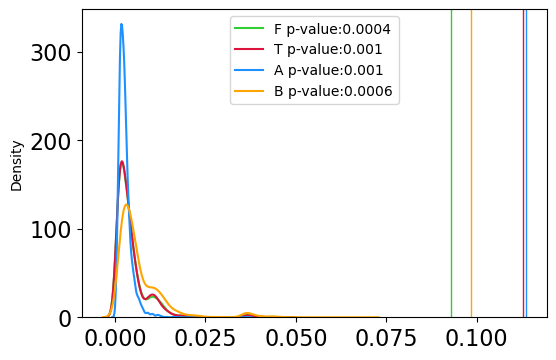

In [232]:
plt.figure(figsize=(6,4))
colorlist=['limegreen','crimson','dodgerblue','orange']
n = 0
labels = ['F','T','A','B']
for k,v in results.items():
    sns.kdeplot(v['permuted_statistics'],color=colorlist[n],label = labels[n]+' p-value:'+str(round(v['p_value'],4)))
    plt.axvline(v['observed_statistic'],linewidth=1,color=colorlist[n])
    n += 1
# plt.xlim(0,0.05)
plt.legend(loc='upper center',fontsize=10)
plt.tick_params(labelsize=16)
plt.savefig('entropy_figs/permutation.png',bbox_inches='tight',dpi=300)


In [220]:
v['observed_statistic']

0.09852373631999559

In [160]:
### peak-separation effect size
def peak_separation_effect_size(entropy_df):
    d_values = []

    for _, row in entropy_df.iterrows():
        values = row.values.astype(float)

        peak = np.max(values)
        non_peak = values[values != peak]

        # handle ties safely
        if len(non_peak) == 0:
            continue

        mu = np.mean(non_peak)
        sigma = np.std(non_peak, ddof=1)

        if sigma == 0:
            continue
        d_values.append((peak - mu) / sigma)

    d_values = np.array(d_values)

    return {
        "regional_d": d_values,
        "global_D_mean": np.mean(d_values),
        "global_D_median": np.median(d_values),
        "n_regions": len(d_values),
    }

In [ ]:
effect_size_df = peak_separation_effect_size(entropy_df[entropy_df.columns[:4]])

/Users/krystal/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/krystal/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [166]:
def eta_squared_scales(entropy_df):
    values = entropy_df.values.flatten()
    grand_mean = values.mean()

    # SS total
    ss_total = np.sum((values - grand_mean) ** 2)

    # SS between scales
    ss_between = 0
    for col in entropy_df.columns:
        col_vals = entropy_df[col].values
        ss_between += len(col_vals) * (col_vals.mean() - grand_mean) ** 2

    eta2 = ss_between / ss_total
    return eta2

In [168]:
eta2 = eta_squared_scales(entropy_df[entropy_df.columns[:4]])

In [169]:
eta2

0.046851757243967715

In [195]:
def cohens_d_scale(entropy_df, peak_scale):
    others = [c for c in entropy_df.columns if c != peak_scale]

    peak_vals = entropy_df[peak_scale].values
    other_vals = entropy_df[others].mean(axis=1).values

    diff = peak_vals - other_vals

    d = diff.mean() / diff.std(ddof=1)

    return d

In [202]:
cohens_d = []
range_r = [0,14,14,23,23,26]
for j in range(3):
    tmp = []
    for i in range(4):
        d = cohens_d_scale(pd.DataFrame(entropy_df[entropy_df.columns[:4]].iloc[range_r[2*j]:range_r[2*j+1]]), entropy_df.columns[i])
        tmp.append(d)
    cohens_d.append(tmp)
cohens_d = np.array(cohens_d)

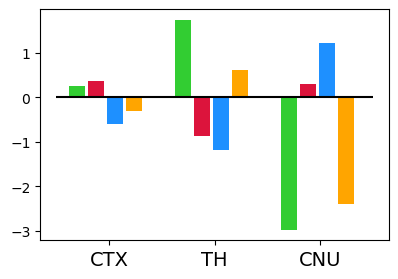

In [253]:
plt.figure(figsize=(4.5,3))
for i in range(4):
    plt.bar([j+i*0.18-0.3 for j in range(3)], cohens_d[:,i], color=colorlist[i],width=0.15)
plt.hlines(0,-0.5,2.5,colors='black')
plt.xticks([i for i in range(3)], ['CTX','TH','CNU'], fontsize=14)
plt.savefig('entropy_figs/cohensD.png',bbox_inches = 'tight', dpi=300)


### Robustness Proof 

In [109]:
entropy_tmp.shape, len(regions), len(scales)

((26, 4), 26, 4)

### Biological Consistency

In [2]:
import pandas as pd 
import numpy as np
import os 

In [5]:
### ctype comparison
full_class_infoTable = pd.read_csv('clusters_all.csv')
ctype_table = pd.read_csv('ctype_mirrored.csv')

In [8]:
ctype_label = []
for i in range(len(full_class_infoTable)):
    name = full_class_infoTable['Name'].iloc[i]
    if name+'.swc' not in list(ctype_table['Unnamed: 0']):
        ctype_label.append('no_label')
    else:
        row_id = ctype_table[ctype_table['Unnamed: 0'] == name+'.swc'].index[0]
        c = ctype_table['detail ctype'].iloc[row_id]
        ctype_label.append(c)
ctype_label = np.array(ctype_label)

In [9]:
### ME
import sys
sys.path.append("/Users/krystal/Desktop/project/pylib-main")
from file_io import load_image, save_image
from anatomy.anatomy_config import MASK_CCF25_FILE, MASK_CCF25_R314_FILE, REGION314, REGION671, SALIENT_REGIONS

In [11]:
ME_map = load_image('../microenvironment/lyf/parc_r671_full.nrrd')

In [18]:
import pickle
with open('../microenvironment/lyf/parc_r671_full.nrrd.pkl','rb') as f:
    ME_name = pickle.load(f) 

In [15]:
ME_label = []
soma_pos = full_class_infoTable[['soma_x','soma_y','soma_z']].values 
soma_pos = soma_pos.astype(np.float64)
soma_pos_int = np.floor(soma_pos/25).astype('int')
parc_ids = ME_map[soma_pos_int[:,2],soma_pos_int[:,1],soma_pos_int[:,0]]

In [14]:
import json
tree_json_path = '../tree_yzx.json'
with open(tree_json_path,'r') as file:
    tree_json = json.load(file)

In [16]:
brain_id_path = {}
id_to_brain = {}
brain_to_id = {}
for i in range(len(tree_json)):
    bid = tree_json[i]['id']
    acronym = tree_json[i]['acronym']
    p = tree_json[i]['structure_id_path']
    if bid not in brain_to_id:
        id_to_brain[bid] = acronym
        brain_to_id[acronym] = bid
    if bid not in brain_id_path:
        brain_id_path[bid] = p

In [23]:
for i in range(len(parc_ids)):
    if parc_ids[i] < 1:
        ME_label.append(-1)
    else:
        rid = ME_name[parc_ids[i]]
        r_name = id_to_brain[rid]
        path_r = brain_id_path[rid]
        org_r_id = brain_to_id[full_class_infoTable['Soma_region'].iloc[i]]
        if org_r_id not in path_r:
            ME_label.append(-1)
        else: 
            ME_label.append(parc_ids[i])
ME_label = np.array(ME_label)

In [53]:
### CP comparison
## ctype:2, ME:13
cp_row_ids = full_class_infoTable[full_class_infoTable['Soma_region'] == 'VPM'].index.tolist()
cp_MMB_id = {}
N = 0
M = 0
MMB_ctype_cp = []
MMB_ME_cp_partial = np.zeros((3,5))
MMB_ME_cp = []
cp_ME_id = {}
for k,v in ME_name.items():
    if v == brain_to_id['VPM']:
        cp_ME_id[k] = M 
        M += 1

for i in range(len(cp_row_ids)):
    if ctype_label[cp_row_ids[i]] == 'no_label':
        ctype_flag = False
    else:
        ctype_flag = True
        ctype_id = int(ctype_label[cp_row_ids[i]].split('_')[1])-1
    ME_id = ME_label[cp_row_ids[i]]

    MMB_name = 'F'+str(full_class_infoTable['full_cluster_2'].iloc[cp_row_ids[i]])+'T'+str(full_class_infoTable['tract_cluster_2'].iloc[cp_row_ids[i]])+'A'+str(full_class_infoTable['arbor_cluster_3'].iloc[cp_row_ids[i]])+'B'+str(full_class_infoTable['bouton_cluster_2'].iloc[cp_row_ids[i]])
    if MMB_name not in cp_MMB_id:
        cp_MMB_id[MMB_name] = N
        N += 1
        if ctype_flag == True:
            tmp = [0 for j in range(2)]
            tmp[ctype_id] += 1
            MMB_ctype_cp.append(tmp)
        else:
            MMB_ctype_cp.append([0 for j in range(2)])

        if (ME_id != -1)&(ME_id in cp_ME_id):
            tmp2 = [0 for j in range(5)]
            tmp2[cp_ME_id[ME_id]] += 1
            MMB_ME_cp.append(tmp2)
            MMB_ME_cp_partial[full_class_infoTable['arbor_cluster_3'].iloc[cp_row_ids[i]]-1,cp_ME_id[ME_id]] += 1
        else:
            MMB_ME_cp.append([0 for j in range(5)])
    else:
        m = cp_MMB_id[MMB_name]
        if ctype_flag == True:
            MMB_ctype_cp[m][ctype_id] += 1
        if (ME_id != -1)&(ME_id in cp_ME_id):
            MMB_ME_cp[m][cp_ME_id[ME_id]] += 1
            MMB_ME_cp_partial[full_class_infoTable['arbor_cluster_3'].iloc[cp_row_ids[i]]-1,cp_ME_id[ME_id]] += 1

MMB_ME_cp = np.array(MMB_ME_cp)
MMB_ctype_cp = np.array(MMB_ctype_cp)

In [254]:
import plotly.graph_objects as go 
import plotly.io as pio
import matplotlib as mpl 
import matplotlib.colors as mcolors 

In [285]:
### sankey
### sankey
color_sankey1 = ['salmon','dodgerblue']
color_sankey2 = mpl.cm.rainbow_r(np.linspace(0,1,11))
color_sankey22 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in color_sankey2]
color_sankey3 = mpl.cm.Accent(np.linspace(0,1,5))
color_sankey33 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in color_sankey3]

nodes = dict(label = ['C1','C2','1','2','3','4','5','6','7','8','9','10','11','M1','M2','M3','M4','M5'],
# label = ['' for i in range(17)],
             color = color_sankey1 + color_sankey22 + color_sankey33
             )
ss = []
ts = []
vs = []
cs = []

for i in range(MMB_ctype_cp.shape[0]):
    for j in range(MMB_ctype_cp.shape[1]):
        ss.append(j)
        ts.append(2+i)
        vs.append(MMB_ctype_cp[i,j])
        cs.append(color_sankey22[i])
            

for i in range(MMB_ME_cp.shape[0]):
    for j in range(MMB_ME_cp.shape[1]):
        ss.append(2+i)
        ts.append(13+j)
        vs.append(MMB_ME_cp[i,j])
        cs.append(color_sankey22[i])
            

links = dict(
        source = ss,
        target = ts,
        value = vs,
        color = cs
    )
layout = go.Layout(
    width = 1000,
    height = 1000,
    font_size = 8
)
data = go.Sankey(node = nodes, link = links)
# data = go.Sankey(node = nodes, link = links)
fig = go.Figure(data,layout=layout)
fig.show()
# pio.write_image(fig,'figs_stats/fun_pattern_all.png',width=400,height=500,scale=3) 

In [288]:
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
import numpy as np

def compute_mutual_information(x, y):
    """
    x, y: categorical arrays
    returns MI in nats
    """
    return mutual_info_score(x, y)

def entropy_from_series(series):
    probs = series.value_counts(normalize=True)
    return entropy(probs)

def normalized_mi(x, y):
    mi = mutual_info_score(x, y)
    hx = entropy_from_series(x)
    hy = entropy_from_series(y)
    return mi / np.sqrt(hx * hy)

def permutation_mi(x, y, n_perm=5000):
    observed = mutual_info_score(x, y)
    perm_vals = np.zeros(n_perm)

    for i in range(n_perm):
        y_perm = np.random.permutation(y)
        perm_vals[i] = mutual_info_score(x, y_perm)

    p_value = (np.sum(perm_vals >= observed) + 1) / (n_perm + 1)
    z_score = (observed - perm_vals.mean()) / perm_vals.std()

    return observed, perm_vals, p_value, z_score

In [290]:
MMB_label = []
MMB_record = {}
n = 0
for i in range(len(full_class_infoTable)):
    MMB_name = 'F'+str(full_class_infoTable['full_cluster_2'].iloc[i])+'T'+str(full_class_infoTable['tract_cluster_2'].iloc[i])+'A'+str(full_class_infoTable['arbor_cluster_3'].iloc[i])+'B'+str(full_class_infoTable['bouton_cluster_2'].iloc[i])
    if MMB_name not in MMB_record:
        MMB_record[MMB_name] = n 
        n += 1
    MMB_label.append(MMB_record[MMB_name])

In [291]:
MMB_label = np.array(MMB_label)

In [297]:
r_selected = ['AId','CP','LGd','VPL','VPM']
rs_mi = []
for i in range(len(r_selected)):
    r_ids = full_class_infoTable[full_class_infoTable['Soma_region'] == r_selected[i]].index.tolist()
    r_ids2 = []
    c = []
    for j in range(len(r_ids)):
        if ctype_label[r_ids[j]] != 'no_label':
            r_ids2.append(r_ids[j])
            c.append(int(ctype_label[r_ids[j]].split('_')[1])-1)
    c = np.array(c)
    m = MMB_label[r_ids2]
    observed, perm_vals, p_value, z_score = permutation_mi(m, c, n_perm=5000)
    rs_mi.append([observed,p_value,z_score])

/var/folders/7l/zhd6m6dn33s94rgr0gyffgq40000gn/T/ipykernel_26635/3052211108.py:31: RuntimeWarning:

invalid value encountered in scalar divide



In [318]:
rs_mi2 = []
for i in range(len(r_selected)):
    r_ids = full_class_infoTable[full_class_infoTable['Soma_region'] == r_selected[i]].index.tolist()
    r_ids2 = []
    me = []
    rs_id = brain_to_id[r_selected[i]]
    if rs_id == 104:
        rs_ids = []
        me_match = {}
        n = 0
        for w in ['AId','AId1','AId2/3','AId5','AId6a','AId6b']:
            w_id = brain_to_id[w]
        
            for k,v in ME_name.items():
                if v == w_id:
                    me_match[k] = n 
                    n += 1
        for j in range(len(r_ids)):
            if (ME_label[r_ids[j]] != -1)&(ME_label[r_ids[j]] in me_match):
                r_ids2.append(r_ids[j])
                me.append(me_match[ME_label[r_ids[j]]])
    else:
        me_match = {}
        n = 0
        for k,v in ME_name.items():
            if v == rs_id:
                me_match[k] = n 
                n += 1
        for j in range(len(r_ids)):
            if (ME_label[r_ids[j]] != -1)&(ME_label[r_ids[j]] in me_match):
                r_ids2.append(r_ids[j])
                me.append(me_match[ME_label[r_ids[j]]])
    me = np.array(me)
    m = MMB_label[r_ids2]
    if len(me) == 0:
        rs_mi2.append([0,0,0])
    else:
        observed, perm_vals, p_value, z_score = permutation_mi(m, me, n_perm=5000)
        rs_mi2.append([observed,p_value,z_score])

/var/folders/7l/zhd6m6dn33s94rgr0gyffgq40000gn/T/ipykernel_26635/3052211108.py:31: RuntimeWarning:

invalid value encountered in scalar divide



In [319]:
rs_mi2

[[0, 0, 0],
 [0.2092992575058193, 0.9612077584483103, -1.6748718399088207],
 [0, 0, 0],
 [0.0, 1.0, nan],
 [0.4654604407962999, 0.11037792441511697, 1.2897883628633022]]

In [320]:
rs_mi

[[0.0, 1.0, nan],
 [0.027793392792663647, 0.0057988402319536095, 3.702596001439993],
 [0.01972845002660991, 0.8184363127374525, -0.8739941410543869],
 [0.027155368638865404, 0.48250349930013997, -0.23780057699571983],
 [0.020246353246822658, 0.10457908418316336, 1.2997053902768387]]